env: PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True


2024-04-22 18:29:45.664095: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-22 18:29:46.717033: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Model: "conv_bodies"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 320, 240,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 316, 236,  │     13,312 │ input_layer[0][0] │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 158, 118,  │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 154, 114,  │  3,277,056 │ max_pooling2d[0]… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 77, 57,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 73, 53,    │    819,328 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 36, 26,    │          0 │ conv2d_2[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 34, 24,    │     73,792 │ max_pooling2d_2[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 17, 12,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 13056)     │          0 │ max_pooling2d_3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │  1,671,296 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ chest_out (Dense)   │ (None, 1)         │        129 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ waist_out (Dense)   │ (None, 1)         │        129 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pelvis_out (Dense)  │ (None, 1)         │        129 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bicep_out (Dense)   │ (None, 1)         │        129 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ thigh_out (Dense)   │ (None, 1)         │        129 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ shoulder_to_wrist_… │ (None, 1)         │        129 │ dense[0][0]       │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leg_out (Dense)     │ (None, 1)         │        129 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ calf_out (Dense)    │ (None, 1)         │        129 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ wrist_out (Dense)   │ (None, 1)         │        129 │ dense[0][0]     

 Total params: 5,856,332 (22.34 MB)

 Trainable params: 5,856,332 (22.34 MB)

 Non-trainable params: 0 (0.00 B)

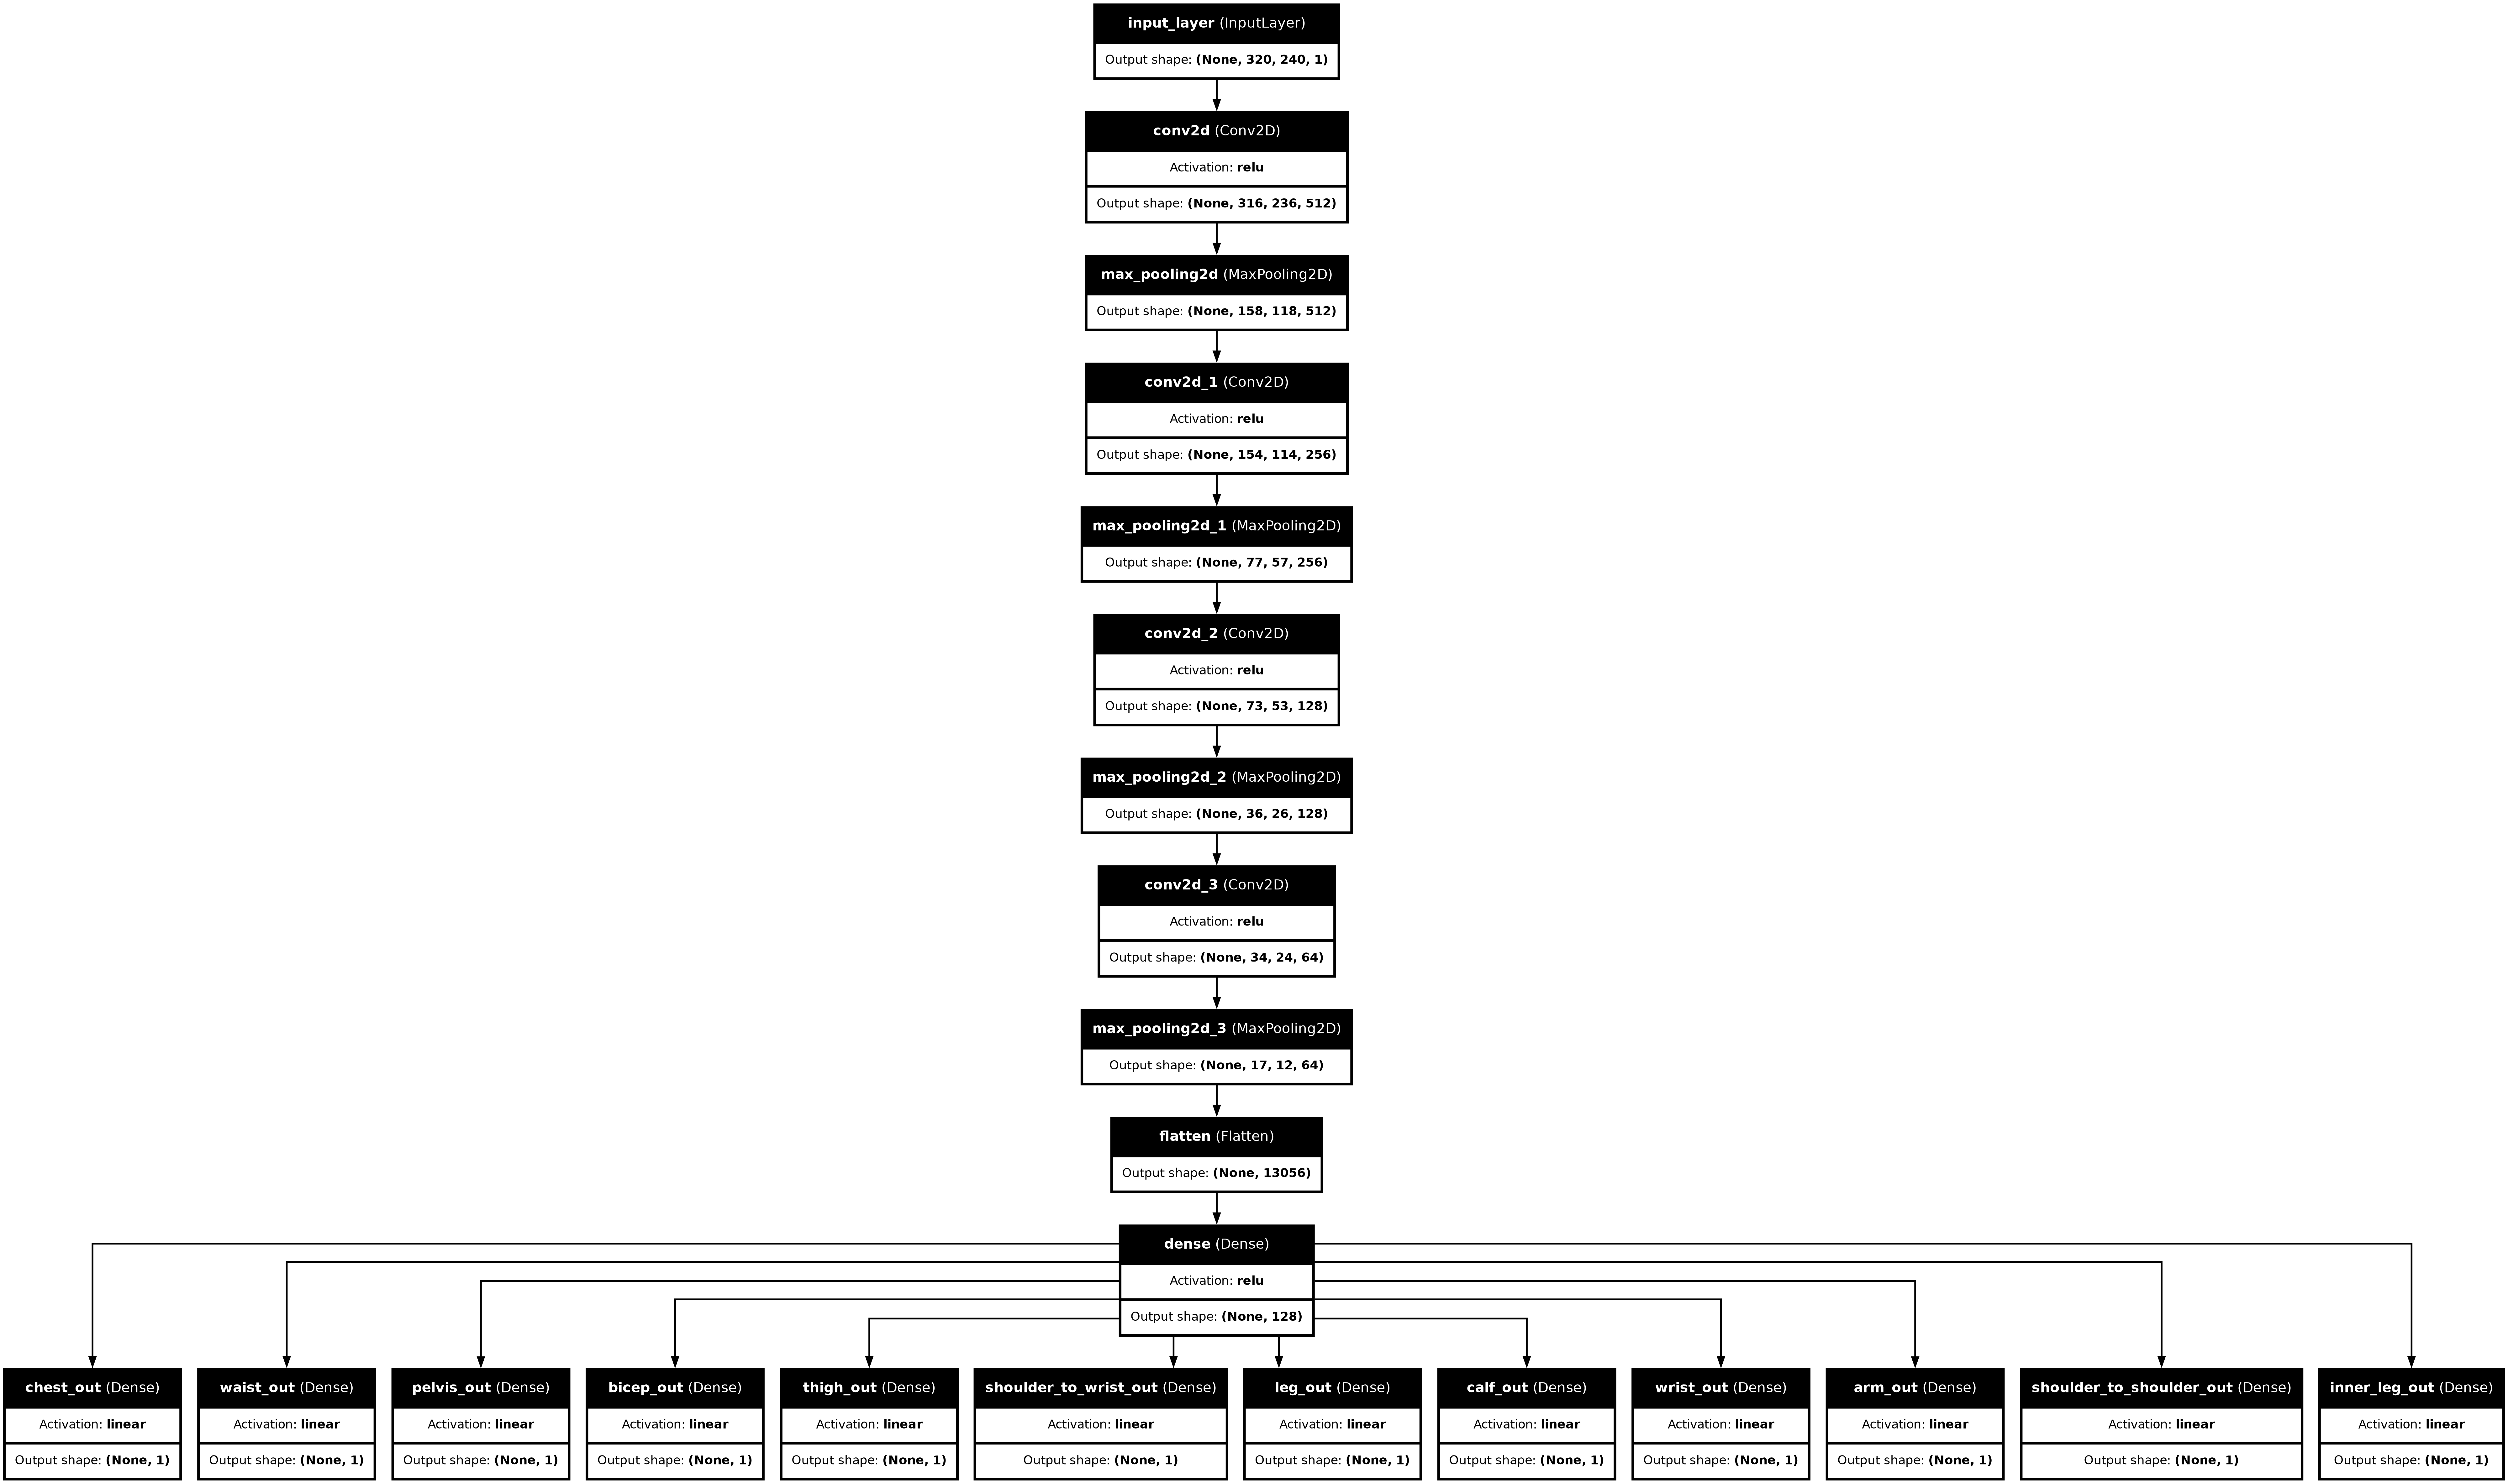

In [1]:
%env PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True
import keras.utils
import numpy as np
from keras.models import Model
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten
import os
import random
import cv2

keras.utils.set_random_seed(42)
np.random.seed(69)
random.seed(69)



inp = Input(shape=(320, 240, 1))

n_filters = 512
max_p = inp

for _ in range(3):
    conv = Conv2D(filters=n_filters, kernel_size=5, activation='relu')(max_p)
    max_p = MaxPooling2D(pool_size=(2, 2))(conv)
    
    n_filters //= 2

conv = Conv2D(filters=n_filters, kernel_size=3, activation='relu')(max_p)
max_p = MaxPooling2D(pool_size=(2, 2))(conv)

flatten = Flatten()(max_p)
dense = Dense(128, activation='relu')(flatten)

chest_out = Dense(1, activation='linear', name='chest_out')(dense)
waist_out = Dense(1, activation='linear', name='waist_out')(dense)
pelvis_out = Dense(1, activation='linear', name='pelvis_out')(dense)
# neck_out = Dense(1, activation='linear', name='neck_out')(dense)
bicep_out = Dense(1, activation='linear', name='bicep_out')(dense)
thigh_out = Dense(1, activation='linear', name='thigh_out')(dense)
# knee_out = Dense(1, activation='linear', name='knee_out')(dense)
shoulder_to_wrist_out = Dense(1, activation='linear', name='shoulder_to_wrist_out')(dense)
leg_out = Dense(1, activation='linear', name='leg_out')(dense)
calf_out = Dense(1, activation='linear', name='calf_out')(dense)
# head_out = Dense(1, activation='linear', name='head_out')(dense)
wrist_out = Dense(1, activation='linear', name='wrist_out')(dense)
arm_out = Dense(1, activation='linear', name='arm_out')(dense)
shoulder_to_shoulder_out = Dense(1, activation='linear', name='shoulder_to_shoulder_out')(dense)
# torso_out = Dense(1, activation='linear', name='torso_out')(dense)
inner_leg_out = Dense(1, activation='linear', name='inner_leg_out')(dense)



model = Model(
    inputs=inp,
    outputs=[
        chest_out,
        waist_out,
        pelvis_out,
        # neck_out,
        bicep_out,
        thigh_out,
        # knee_out,
        shoulder_to_wrist_out,
        leg_out,
        calf_out,
        # head_out,
        wrist_out,
        arm_out,
        shoulder_to_shoulder_out,
        # torso_out,
        inner_leg_out
    ],
    name='conv_bodies'
)


###TRAINING VARIABLES

sample_count = 79998
epoch_count = 10
validation_count = 20000
initial_learning_rate=.001
decay_steps=8888
decay_rate=0.97
dataset_name = "SuToBoCM v2"

folder_path = f"{dataset_name} - {sample_count}s{epoch_count}e{validation_count}v {"" if initial_learning_rate == 0.001 else initial_learning_rate + "ilr"}{decay_steps}s{decay_rate}d"

try:
    os.mkdir(os.path.join("./logs/" + folder_path))
except OSError as error:
    print(error)
    

#model.save_weights("default.weights.h5")

# model.summary()
# 
# from keras.utils import plot_model
# 
# plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True, show_layer_activations=True)

In [2]:
class Database_Loader(keras.utils.Sequence):
    
    def __init__(self, image_location, data_location, sample_count, batch_size, dataset = "Surreact", shuffle=True, seed=0, input_dimensions=(240, 320), prefix="Avatar_", use_memory=False, load_data = True, random_sample = False):
        self.image_location = image_location
        self.data_location = data_location
        self.sample_count = sample_count
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.seed = seed
        self.input_dimensions = input_dimensions
        self.prefix = prefix
        self.use_memory = use_memory
        self.load_data = load_data
        self.random_sample = random_sample
        self.dataset = dataset

        
        try:
            os.remove("./dataflowValid.txt")
        except:
            pass

        if self.random_sample:
            self.IDs = random.sample(range(len(os.listdir(self.image_location))),self.sample_count)
        else:
            self.IDs = [x for x in range(self.sample_count)]
            # self.IDs = [22823, 11011, 4372, 19543, 41443, 13198, 62691, 20607, 1845, 37300]
            # self.IDs = [2108,37222,2085,43309,13652,66910,19390,54061,12194]            
            self._load_data()

        super().__init__(workers=1, use_multiprocessing=False)
        self.on_epoch_end()
        
    def __len__(self):
        return int(np.floor(self.sample_count / self.batch_size))
    
    
    def _load_data(self):
        if self.load_data:
            self.data = dict()
            for index in self.IDs:
                self.data[index] = np.load(os.path.join(self.data_location + self.prefix + f"{index:06d}.npy"))

        if self.use_memory:
            self.images = dict()
            for index in self.IDs:
                self.images[index] = cv2.imread(os.path.join(self.image_location + self.prefix + f"{index:06d}.png"), cv2.IMREAD_GRAYSCALE)
    
    def __getitem__(self, index):
        X = np.empty(shape=(self.batch_size, 320, 240))
        y = {
            'chest_out': [],
            'waist_out': [],
            'pelvis_out': [],
            # 'neck_out': [],
            'bicep_out': [],
            'thigh_out': [],
            # 'knee_out': [],
            'shoulder_to_wrist_out': [],
            'leg_out': [],
            'calf_out': [],
            # 'head_out': [],
            'wrist_out': [],
            'arm_out': [],
            'shoulder_to_shoulder_out': [],
            # 'torso_out': [],
            'inner_leg_out': [],
        }

        start_index = index * self.batch_size + 1
        with open(f"./dataflowValid.txt", "a") as validationFile:
            for i in range(self.batch_size):
                name = f"{self.IDs[(start_index + i)%self.sample_count]:06d}"
                
                
                if self.load_data:
                    current_measurement = self.data[self.IDs[(start_index + i)%self.sample_count]][:-1]          
                else:
                    current_measurement = np.load(os.path.join(self.data_location + self.prefix + name + ".npy"))[:-1]
                    
                if self.use_memory:
                    X[i,] = self.images[self.IDs[(start_index + i)%self.sample_count]]
                    
                else:
                    X[i,] = cv2.imread(os.path.join(self.image_location + self.prefix + name + ".png"), cv2.IMREAD_GRAYSCALE)
                    
                if self.dataset == "Surreact":
                    y['chest_out'].append([current_measurement[0]])
                    y['waist_out'].append([current_measurement[1]])
                    y['pelvis_out'].append([current_measurement[2]])
                    # y['neck_out'].append([current_measurement[3]])
                    y['bicep_out'].append([current_measurement[4]])
                    y['thigh_out'].append([current_measurement[5]])
                    # y['knee_out'].append([current_measurement[6]])
                    y['shoulder_to_wrist_out'].append([current_measurement[7]])
                    y['leg_out'].append([current_measurement[8]])
                    y['calf_out'].append([current_measurement[9]])
                    # y['head_out'].append([current_measurement[10]])
                    y['wrist_out'].append([current_measurement[11]])
                    y['arm_out'].append([current_measurement[12]])
                    y['shoulder_to_shoulder_out'].append([current_measurement[13]])
                    # y['torso_out'].append([current_measurement[14]])
                    y['inner_leg_out'].append([current_measurement[15]])
                validationFile.write(name + "\n")
            validationFile.write("END OF BATCH===========================================\n\n")

        for key, value in y.items():
            y[key] = np.array(value)
            
        return X, y
    
    def on_epoch_end(self):
        if self.random_sample:
            self.IDs = random.sample(range(len(os.listdir(self.image_location))),self.sample_count)
            self._load_data()

        if self.shuffle:
            np.random.shuffle(self.IDs)
        else:
            self.IDs = np.arange(self.sample_count)
         

In [3]:
quickTrain = {
                'image_location': "../Surreact-APose/train/imgs_nobg_frontEDITED/", 
                'data_location': "../Surreact-APose/train/measurementsCM/", 
                'sample_count': sample_count, 
                'batch_size': 9, 
                'seed':  69,#np.random.randint(0, 10000), 
                'use_memory': False,
                'random_sample': False,
                'shuffle': True}

quickValidate = {
                'image_location': "../Surreact-APose/test/imgs_nobg_frontEDITED/",
                'data_location': "../Surreact-APose/test/measurementsCM/",
                'sample_count': validation_count,
                'batch_size': 9,
                'seed': 69, #np.random.randint(0, 10000),
                'use_memory': False,
                'random_sample': False}

realDataTest = {
                'image_location': "../bodym-dataset/front/images/",
                'data_location': "../bodym-dataset/front/measurements/",
                'sample_count': 8978,
                'batch_size': 4,
                'use_memory': False,
                'random_sample': False,
                'shuffle': False}

train_generator = Database_Loader(**quickTrain)
validation_generator = Database_Loader(**quickValidate)

In [4]:
from keras.optimizers import Adam
from keras.callbacks import TensorBoard, ModelCheckpoint
from keras.losses import MeanSquaredError
from keras_tqdm import TQDMNotebookCallback


lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=initial_learning_rate,
    decay_steps=decay_steps,
    decay_rate=decay_rate,
    staircase=True)


model.compile(
    optimizer=Adam(learning_rate=lr_schedule),
    loss={
        'chest_out': MeanSquaredError(),
        'waist_out': MeanSquaredError(),
        'pelvis_out': MeanSquaredError(),
        # 'neck_out': MeanSquaredError(),
        'bicep_out': MeanSquaredError(),
        'thigh_out': MeanSquaredError(),
        # 'knee_out': MeanSquaredError(),
        'shoulder_to_wrist_out': MeanSquaredError(),
        'leg_out': MeanSquaredError(),
        'calf_out': MeanSquaredError(),
        # 'head_out': MeanSquaredError(),
        'wrist_out': MeanSquaredError(),
        'arm_out': MeanSquaredError(),
        'shoulder_to_shoulder_out': MeanSquaredError(),
        # 'torso_out': MeanSquaredError(),
        'inner_leg_out': MeanSquaredError()
    },
    metrics={
        'chest_out': ['mae'],
        'waist_out': ['mae'],
        'pelvis_out': ['mae'],
        # 'neck_out': ['mae'],
        'bicep_out': ['mae'],
        'thigh_out': ['mae'],
        # 'knee_out': ['mae'],
        'shoulder_to_wrist_out': ['mae'],
        'leg_out': ['mae'],
        'calf_out': ['mae'],
        # 'head_out': ['mae'],
        'wrist_out': ['mae'],
        'arm_out': ['mae'],
        'shoulder_to_shoulder_out': ['mae'],
        # 'torso_out': ['mae'],
        'inner_leg_out': ['mae'],
    },
)



checkpoint_filepath = './models/checkpoint.model.keras'
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='loss',
    mode='min',
    save_best_only=True)

model.fit(
    x=train_generator,
    validation_data=validation_generator,
    callbacks=[
        
        TensorBoard(write_graph=True,log_dir="./logs/"+folder_path, update_freq="batch"),
        TQDMNotebookCallback(separator="", metric_format="{name}: {value:0.8f} || "),
        model_checkpoint_callback,
    ],
    batch_size=9,
    epochs=epoch_count,
    verbose=0
)

model.save("./models/full/model.keras")
# 
# for i in range(10000):
#     image = cv2.imread(f"../Surreact-APose/train/imgs_nobg_frontEDITED/Avatar_{6969+i:06d}.png", cv2.IMREAD_GRAYSCALE)
# 
#     print(model.predict(np.array([image])))
#     

2024-04-22 18:30:02.229324: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-22 18:30:02.232942: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-22 18:30:02.233118: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Training:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0:   0%|          | 0/8888 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
# from keras.models import load_model
# import cv2
# import numpy as np
# model = load_model("./models/checkpoint.model.keras")
# 
# #ankle	arm-length	bicep	calf	chest	forearm	height	hip	leg-length	shoulder-breadth	shoulder-to-crotch	thigh	waist	wrist
# 
# 
# def printResults(name, val1, val2):
#     if val2 == "N/A":
#         print(name, " - ", val1, val2)
#         return 
#     print(name, " - ", val1, val2, " error - ", abs(val1 - val2))
# 
# 
# 
# 
# for i in range(1):
#     image = cv2.imread(f"../bodym-dataset/front/images/Avatar_{i:06d}.png", cv2.IMREAD_GRAYSCALE)
#     data = np.load(f"../bodym-dataset/front/measurements/Avatar_{i:06d}.npy")
#     predictions = model.predict(np.array([image]))
#     printResults("Head", predictions[0], "N/A")
#     printResults("Neck", predictions[1], "N/A")
#     printResults("Shoulder to shoulder", predictions[2], data[9]/100)
#     printResults("Shoulder to wrist", predictions[3], data[1]/100)
#     printResults("Torso", predictions[4], "N/A")
#     printResults("Bicep", predictions[5], data[2]/100)
#     printResults("Wrist", predictions[6], data[13]/100)
#     printResults("Chest", predictions[7], data[4]/100)
#     printResults("Waist", predictions[8], data[12]/100)
#     printResults("Pelvis", predictions[9], data[6]/100)
#     printResults("Inner leg", predictions[10], data[7]/100)
#     printResults("Thigh", predictions[11], data[11]/100)
#     printResults("Knee", predictions[12], "N/A")
#     printResults("Calf", predictions[13], data[3]/100)
    

In [ ]:
#Averages
# import pandas
# 
# measures = train_generator.data
# col = ["chest", "waist", "pelvis", "neck", "bicep","thigh", "knee", "arm", "leg", "calf", "head", "wrist", "armSpan", "shoulder", "torso","iLeg", "height"]
# df = pandas.DataFrame(measures.values(), columns=col)
# for i in col:
#     print(i, df.loc[:, i].mean())

In [ ]:
# #Data modifiaction

import os
from tqdm import tqdm

avatar_count = 1
counter = 0

for number in tqdm(range(avatar_count)):
    file = (tuple(np.load(f"../Surreact-APose/train/bodymeasurements/Avatar_{number:06d}.npy", allow_pickle=True)))
    measurements = []
    for value in file:
        measurements.append(float(value * 100))
    counter += 1

In [ ]:
#Image modification
# 
# import os
# import cv2
# import numpy as np
# from tqdm import tqdm
# 
# 
# avatar_count = 20000
# counter = 0
# 
# for number in tqdm(range(avatar_count)):
#     image = cv2.imread(f"../Surreact-APose/test/imgs_nobg_front/Avatar_{number:06d}.png", cv2.IMREAD_UNCHANGED)
#     alpha_channel = image[:, :, 3]
#     body_indices = alpha_channel > 30
#     image[body_indices] = [255, 255, 255, 255]
#     indices = np.where(body_indices)
#     leftmost_pixel = np.min(indices[1])
#     rightmost_pixel = np.max(indices[1])
#     topmost_pixel = max(np.min(indices[0]), 0)
#     bottommost_pixel = min(np.max(indices[0]), 239)
#     image = cv2.cvtColor(image, cv2.COLOR_mRGBA2RGBA)
#     cropped = image[topmost_pixel:bottommost_pixel, leftmost_pixel:rightmost_pixel]
# 
#     border_height = 320 - cropped.shape[0]
#     border_width = 240 - cropped.shape[1]
# 
#     # Calculate the border sizes
#     top_border = border_height // 2
#     bottom_border = border_height - top_border
#     left_border = border_width // 2
#     right_border = border_width - left_border
# 
#     # Add the border
#     bordered_image = cv2.copyMakeBorder(cropped, top_border, bottom_border, left_border, right_border, cv2.BORDER_CONSTANT, value=(0,0,0,0))
# 
# 
#     cv2.imwrite(f"../Surreact-APose/test/imgs_nobg_frontEDITED/Avatar_{counter:06d}.png", bordered_image)
#     counter +=1

In [ ]:
# Image validation

# import os
# import cv2
# import numpy as np
# from tqdm import tqdm
# 
# 
# avatar_count = 79998
# counter = 0
# 
# for number in tqdm(range(avatar_count)):
#     image = cv2.imread(f"../Surreact-APose/train/imgs_nobg_front/Avatar_{number:06d}.png", cv2.IMREAD_UNCHANGED)
#     if image.shape != (240, 320, 4):
#         print(image.shape, number)
#     counter +=1

In [ ]:
# #FOR BODY_M DATASET
# import csv
# import numpy as np
# import os
# 
# import cv2
# import tqdm.notebook
# 
# counter = 0
# for folder in tqdm.notebook.tqdm(["train","testA","testB"]):
# 
#     with open('../bodym-dataset/'+folder+'/subject_to_photo_map.csv', 'r') as f:
#         reader = csv.reader(f)
#         uuid_raw = list(reader)
#     from collections import defaultdict
# 
#     uuid_map = defaultdict(list)
# 
#     for subject_id, photo_id in uuid_raw[1:]:
#         uuid_map[subject_id].append(photo_id)
#     image_data = {}
# 
#     with open('../bodym-dataset/'+folder+'/measurements.csv', 'r') as f:
#         reader = csv.reader(f)
# 
#         for line in reader:
#             subject_id = line[0]
# 
# 
#             for image_id in uuid_map[subject_id]:
#                 image_data[image_id] = np.array(list(map(float, line[1:])))
# 
# 
#     for subject_id, images in tqdm.notebook.tqdm(uuid_map.items()):
#         for image in images:
#             measurements = np.array(image_data[image])
#             silhouette = cv2.imread(os.path.join('../bodym-dataset/'+folder+'/mask/' + image + '.png'), cv2.IMREAD_GRAYSCALE)
#             silhouette = cv2.resize(silhouette,(240, 320)) #may be wrong
#             cv2.imwrite(os.path.join(f'../bodym-dataset/front/images/Avatar_{counter:06d}.png'), silhouette)
#             np.save(os.path.join(f'../bodym-dataset/front/measurements/Avatar_{counter:06d}.npy'), measurements)
#             counter += 1
